## Colab setup Instructions

- Click Runtime -> Run all
- After the error, go to Runtime -> Restart and run all

In [1]:
import sys
import os
from subprocess import run


def r(cmd: str):
    if os.environ.get('TERM').startswith('xterm'):
        print(f'\x1b[31m$ {cmd}\x1b[0m', flush=True, file=os.sys.stderr)
    else:
        print(f'$ {cmd}', flush=True, file=os.sys.stderr)

    return run(cmd, shell=True, check=True)


def setup_colab():
    r('git clone https://github.com/UlisseMini/procgen-tools')
    os.chdir('procgen-tools')
    r('pip install -e .')
    r('pip install -r requirements.txt || true')  # fails due to a warning sometimes
    r('mkdir -p data/vfields figures trained_models/maze_I')
    r('wget https://nerdsniper.net/mats/episode_data.tgz && tar -xzf episode_data.tgz'
      )
    r('wget https://nerdsniper.net/mats/data.tgz && tar -xzf data.tgz')
    r('wget https://nerdsniper.net/mats/model_rand_region_5.pth -O trained_models/maze_I/model_rand_region_5.pth'
      )
    os.chdir('experiments')


if 'google.colab' in sys.modules:
    if os.path.exists('procgen-tools'):
        os.chdir('procgen-tools/experiments')
    elif 'procgen-tools' not in os.getcwd():
        setup_colab()

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from procgen_tools import maze
import pickle
import numpy as np
from glob import glob
from collections import defaultdict

plt.rcParams['figure.dpi'] = 140

## Introduction

We're looking at the maze solving agents from the [goal misgeneralization](https://arxiv.org/abs/2105.14111) paper. In particular, the agents trained to find cheese in a maze.

We have a variety of ways to look at and manipulate mazes
1. The human view (rarely used now, we've gotten comfortable looking at grids)
2. The agent view (what the agent sees)
3. The grid/numpy view (easy to manipulate in code)

--------------------------------------------------------------------------
The library attempted to open the following supporting CUDA libraries,
but each of them failed.  CUDA-aware support is disabled.
libcuda.so.1: cannot open shared object file: No such file or directory
libcuda.dylib: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.so.1: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.dylib: cannot open shared object file: No such file or directory
If you are not interested in CUDA-aware support, then run with
--mca opal_warn_on_missing_libcuda 0 to suppress this message.  If you are interested
in CUDA-aware support, then try setting LD_LIBRARY_PATH to the location
of libcuda.so.1 to get passed this issue.
--------------------------------------------------------------------------


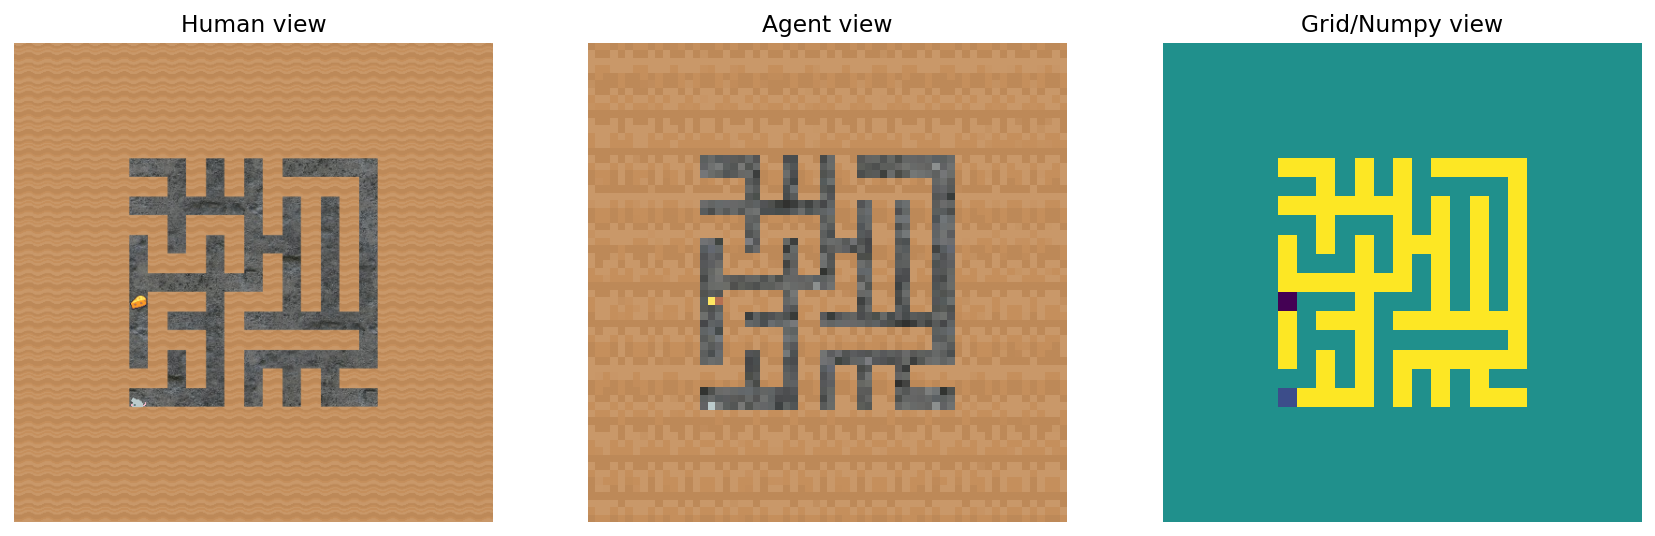

In [3]:
venv = maze.create_venv(num=1, start_level=0, num_levels=1)
fig, ax = plt.subplots(1,3, figsize=(15, 5))

human_view = venv.env.get_info()[0]['rgb']
agent_view = venv.reset()[0].transpose(1,2,0)
grid_view = maze.EnvState(venv.env.callmethod('get_state')[0]).full_grid()[::-1, :]
for (a, img, title) in zip(ax, [human_view, agent_view, grid_view], ['Human view', 'Agent view', 'Grid/Numpy view']):
    a.axis('off')
    a.imshow(img)
    a.set_title(title)

plt.show()

### Explore episodes interactively

Here you can explore a bunch of episodes from the `rand_region_5` agent, trained to get the cheese when the cheese always spawned in the top right 5x5 region of the maze.
These mazes were generated with the cheese in any position though, so there's a conflict between the "top-right shard" and the "cheese shard"

In [4]:
from procgen_tools import maze
from circrl.rollouts import load_saved_rollout
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

# rand_region_5 model on all mazes, load 100 (uses a lot of memory)
files = glob('../episode_data/20230131T032642/*.dat')[:100]
rollouts = [load_saved_rollout(f) for f in tqdm(files)]

from procgen_tools.maze import EnvState
from ipywidgets import interact, IntSlider

episode_slider = IntSlider(min=0, max=len(rollouts)-1, step=1, value=0)
timestep_slider = IntSlider(min=0, max=256, step=1, value=0)

@interact
def show_episodes(ep = episode_slider, timestep = timestep_slider):
    timestep_slider.max = len(rollouts[ep]['seq'].obs)-1
    state = EnvState(rollouts[ep]['seq'].custom['state_bytes'][timestep].item())
    plt.imshow(state.inner_grid(), origin='lower')

100%|██████████| 100/100 [00:01<00:00, 85.80it/s]


interactive(children=(IntSlider(value=0, description='ep', max=99), IntSlider(value=0, description='timestep',…

### The vector field view

A nicer way to view episodes is with a **vector field view**, which overlays a vector-field representing the agent policy for a given maze, and are computed as follows:

1. Take the output probabilities from the policy $(p_{\text{left}}, p_{\text{right}}, p_{\text{up}}, p_{\text{down}})$ at every mouse position
2. Compute the x and y components of the vector as $x = p_{\text{right}} - p_{\text{left}}$ and $y = p_{\text{down}} - p_{\text{up}}$


Generating the vector fields is a bit slow (~1s/each), so we'll load them from a precomputed dataset.

In [5]:
vfields = [pickle.load(open(f, 'rb')) for f in glob('../data/vfields/seed-*.pkl')]
vfields_by_level = defaultdict(list)
for vf in vfields:
    vfields_by_level[vf['seed']].append(vf)
def get_vfields(seed: int, coeff: float):
    return next(vf for vf in vfields_by_level[seed] if vf['coeff'] == coeff)

In [6]:
from ipywidgets import interact, IntSlider, FloatSlider
from procgen_tools import vfield
import procgen_tools.vfield_stats as vs

@interact(seed=IntSlider(min=0, max=max(vf['seed'] for vf in vfields), step=1, value=0))
def interact_vfields(seed: int):
    vfield.plot_vf(vfields_by_level[seed][0]['original_vfield'])

interactive(children=(IntSlider(value=0, description='seed', max=99), Output()), _dom_classes=('widget-interac…

## Model editing: Finding a "cheese" vector

"What's the stupidest first thing we could try? What if taking the difference in activations at a certain layer gave us a "cheese" vector? Could we subtract this from the activations to make the mouse ignore the cheese?"

Surprisingly, this (sort-of) works. Take a maze, make a copy with no cheese, record the difference in activations at a particular layer (`embedder.block2.res1.resadd_out` seemed to work best in our experiments though we don't yet understand why), then patch the network by adding (or subtracting) this difference to the activations at that layer.

### Interactively explore the effect of the cheese vector

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
from glob import glob
from collections import defaultdict

In [8]:
vfields = [pickle.load(open(f, 'rb')) for f in glob('../data/vfields/seed-*.pkl')]
vfields_by_level = defaultdict(list)
for vf in vfields:
    vfields_by_level[vf['seed']].append(vf)
def get_vfields(seed: int, coeff: float):
    return next(vf for vf in vfields_by_level[seed] if vf['coeff'] == coeff)

In [9]:
from ipywidgets import interact, IntSlider, FloatSlider

def _coeffs_for(seed: int):
    return sorted(set(vf['coeff'] for vf in vfields_by_level[seed]))


seed_max = max(vf['seed'] for vf in vfields)
min_coeff, max_coeff = min(vf['coeff']
                           for vf in vfields), max(vf['coeff']
                                                   for vf in vfields)


@interact(seed=IntSlider(min=0, max=seed_max, step=1, value=0),
          coeff=FloatSlider(min=min_coeff, max=max_coeff, step=0.1, value=-1.0))
def interact_vfields(seed: int, coeff: float):
    # set coeff to nearest available in vfields_by_level[seed]
    coeff = min(_coeffs_for(seed), key=lambda x: abs(x - coeff))
    vfs = get_vfields(seed, coeff)
    vs.plot_vfs(vfs)

interactive(children=(IntSlider(value=0, description='seed', max=99), FloatSlider(value=-1.0, description='coe…

### Qunatifying the effect of subtracting the "cheese vector"


To see the statistical change in propensity to go to the cheese, we can look at the probability of going to the cheese when there's a fork in the maze, with cheese on one side and the top-right on the other. Plotting the difference in probabilities gives us the following:

(Note: We're *subtracting* the cheese vector, so the probability of going to the cheese should be lower, and the probability of going to the top right (or towards neither) should be higher.)

In [10]:
from ipywidgets import Dropdown

@interact
def boxplot_interactive(coeff = Dropdown(options=_coeffs_for(0), value=-1.0)):
    dprobs_original, dprobs_patched = vs.get_decision_probs_original_and_patched(vfields, coeff=coeff)
    dpo, dpp = dprobs_original, dprobs_patched
    dpo = np.stack([dpo[:,0], dpo[:,1], 1-dpo[:,0]-dpo[:,1]], axis=1)
    dpp = np.stack([dpp[:,0], dpp[:,1], 1-dpp[:,0]-dpp[:,1]], axis=1)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(3):
        ax[i].boxplot([dpo[:,i], dpp[:,i]], showmeans=True, meanline=True)
        ax[i].set_xticks([1, 2])
        ax[i].set_xticklabels(['original', 'patched'])
        ax[i].set_title([f'P({label} | decision-square)' for label in ('cheese', 'top-right', 'other')][i])


    vs.plot_decision_probs(dprobs_original, dprobs_patched)

interactive(children=(Dropdown(description='coeff', index=3, options=(-3, -2, -1.5, -1, -0.5, 0.5, 1, 1.5, 2, …

### What about generalization?

We're doing something quite specific here, taking in the maze `M`, recording activations, editing it to have no cheese, recording activations, and then subtracting the two. If we're truely finding a "cheese vector / cheese abstraction" we'd be able to generalize from one maze to another, and create a saved copy of the model which ignores the cheese in any maze.